# Bike Count Data Preprocessing Notebook

[Add notes]

## Read in Extracted Data

In [34]:
# libraries
import sys
from pathlib import Path
import pandas as pd
import folium
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# define directory variables
REPO_ROOT = Path.cwd().parent
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))
DATA_DIR = REPO_ROOT / 'data'
EXTRACTED_DIR = DATA_DIR / 'extracted'
PROCESSED_DIR = DATA_DIR / 'processed'
DATA_DIR.mkdir(exist_ok=True)

In [35]:
# read in extracted bike count data
df = pd.read_parquet(EXTRACTED_DIR / 'extracted_hourly_bike_count_data.parquet')

print(df.shape)
display(df.head())

(682204, 8)


,year,date_time_dt,site_id,site_name,counter_id,counter_name,count,coords
452,2019,2019-01-01 07:00:00+01:00,100047535-100047551,pont du garigliano,100047535-SC,pont du garigliano no-se,3,"48.839927,2.267151"
453,2019,2019-01-04 02:00:00+01:00,100047535-100047551,pont du garigliano,100047535-SC,pont du garigliano no-se,1,"48.839927,2.267151"
454,2019,2019-01-07 06:00:00+01:00,100047535-100047551,pont du garigliano,100047535-SC,pont du garigliano no-se,13,"48.839927,2.267151"
455,2019,2019-01-07 07:00:00+01:00,100047535-100047551,pont du garigliano,100047535-SC,pont du garigliano no-se,55,"48.839927,2.267151"
456,2019,2019-01-07 08:00:00+01:00,100047535-100047551,pont du garigliano,100047535-SC,pont du garigliano no-se,114,"48.839927,2.267151"


## Site Locations

The bike count data files were generated yearly. To better understand the geographic locations of the counter sites, here we visualize them on a map with the latitude and longitude values provided.

In [36]:
# clean and split coordinates values
s = (df['coords'].astype(str).str.strip().str.replace(r"\s+", "", regex=True))
latlon = s.str.split(",", expand=True)
df["lat"] = pd.to_numeric(latlon[0], errors="coerce")
df["lon"] = pd.to_numeric(latlon[1], errors="coerce")

# select and subset to coordinates
df_coord = df.dropna(subset=["lat", "lon"]).copy()
df_coord = df_coord[['site_id', 'site_name', 'lat', 'lon']]

# round to reduce tiny differences ; 4 decimals is approximately 11 meters
df_coord["lat_r"] = df_coord["lat"].round(4)
df_coord["lon_r"] = df_coord["lon"].round(4)

# subset to unique cases
unique_sites = df_coord[['site_id', 'site_name', 'lat_r', 'lon_r']].drop_duplicates().sort_values(by='site_name')

# display all the unique site locations
display(unique_sites)

,site_id,site_name,lat_r,lon_r
452,100047535-100047551,pont du garigliano,48.8399,2.2672
11689,100047535-100047551,pont du garigliano,48.8399,2.2671
611360,100047535-100047551,pont du garigliano,48.8402,2.2673
776072,100047535-100047551,pont du garigliano,48.8399,2.2669
10811,100047541-100047549,pont national,48.8268,2.3846
14398,100047541-100047549,pont national,48.8265,2.3843
663569,100047541-100047549,pont national,48.8266,2.3841
2885468,100047541-100047549,pont national,48.8264,2.3845
4458412,100047541-100047549,pont national,48.8268,2.3849
23148,100047546,quai de bercy,48.8295,2.3870


In [37]:
from scripts.plot_site_map import plot_site_map

# plot site with a marker for each lat/lon location what was associated with a counter
plot_site_map(unique_sites)

### Site Location Observations

- The map confirms that the five counter sites form five distinct geographic clusters.
- Reported latitude and longitude values vary across years, indicating that counters associated with a given site were repositioned over time or that their recorded locations changed due to measurement or reporting effects. The available data do not allow these possibilities to be distinguished.

---
## Counter Devices

Exploratory analysis of the counter data revealed that:

1) many zero-count days were recorded, which—given the traffic volume in Paris—strongly suggests periods of non-operation rather than true zero counts
2) the number of counters at a given site was not stable over time.
3) the pont du garigliano and pont nationale sites used two site_id values for counters that measure traffic in opposite directions across the bridge

### Zero-Count Days Analysis

Here we will visualize the zero-count days at each counter to better understand their patterns of operation.
To better understand counter operation, we examine the zero-count periods for each device.

In [38]:
from scripts.compute_zero_runs import compute_zero_runs

# compute the runs of zero-count days for each counter
    # compute daily counts per counter
    # subset to zero count days
    # compute consequative days of zero days (i.e., a run of zero days) using the date_time_dt variable
    # prepare result for ploting
zero_runs = compute_zero_runs(df, min_run_days = 1)

# show result
display(zero_runs)

,counter_id,run_id,start,end,n_days,start_num,end_num,width,y
0,100047541-SC,1,2019-12-31,2019-12-31,1,18261.0,18261.0,1.0,0
1,100047541-SC,2,2020-03-04,2020-03-04,1,18325.0,18325.0,1.0,0
2,100047541-SC,3,2020-03-10,2020-03-10,1,18331.0,18331.0,1.0,0
3,100047541-SC,4,2020-03-17,2020-03-17,1,18338.0,18338.0,1.0,0
4,100047541-SC,5,2020-03-21,2020-03-21,1,18342.0,18342.0,1.0,0
...,...,...,...,...,...,...,...,...,...
140,100047546-103047546,141,2019-12-31,2019-12-31,1,18261.0,18261.0,1.0,5
141,100047549-SC,142,2019-09-13,2019-09-13,1,18152.0,18152.0,1.0,6
142,100047549-SC,143,2019-09-15,2019-09-22,8,18154.0,18161.0,8.0,6
143,100047551-102047551,144,2019-12-31,2019-12-31,1,18261.0,18261.0,1.0,7


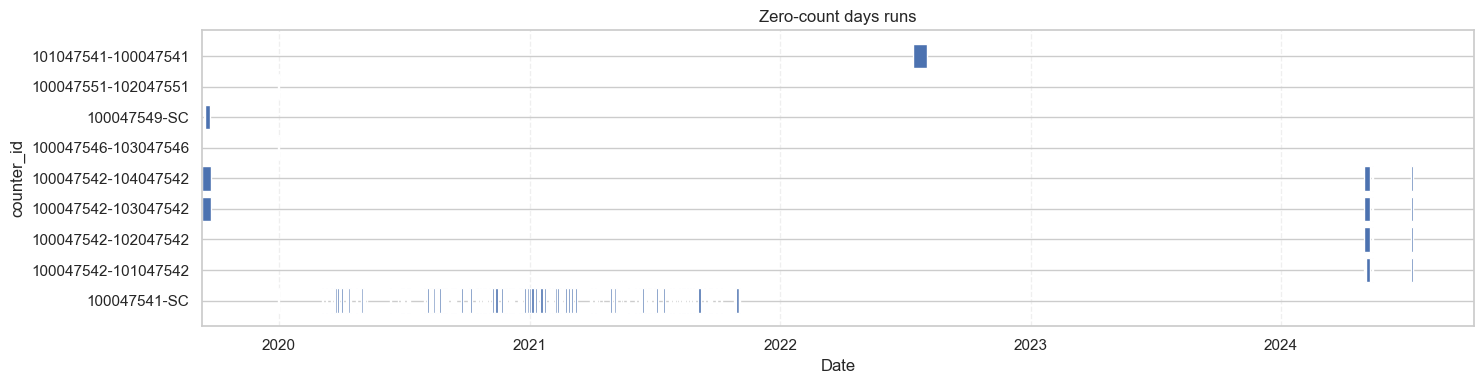

In [19]:
from scripts.plot_zero_runs import plot_zero_runs
# plot the runs of zero-count days over the span of 2019-2024 in a horizontal bar chart
plot_zero_runs(zero_runs, figsize=(15,4))

### Zero-Count Days: Observations

- Counters 101047541-100047541 recorded uninterrupted zero counts for 21 days in 2022.
- Counter 100047541-SC displayed sporatic zero count days during 2020 and 2021
- For all other counters, zero-count days occurred in temporally aligned runs across multiple devices, rather than sporadically.

### Zero-Count Days: Interpretation

The zero-count patterns are unlikely to represent true zero traffic. Given Paris’s consistently high cycling activity, zero counts are implausible. Moreover, the temporal alignment of many of the zero-count runs across counters indicates temporary but systematic periods of non-operation. These zero values will be recoded as missing (NaN).

Counter 100047541-SC's zero-day pattern was unique among all the counters. While the underlying cause of this pattern is unclear, its zero days are treated consistently as missing data and do not materially affect site-level aggregation or normalization steps performed below. As the pattern does not produce sustained gaps or anomalous trends, no further action was taken.

In [39]:
# assign NaN to hourly counts of zero-count days

# copy data
df2 = df.copy()

# create day variable
df2['day'] = df2['date_time_dt'].dt.date 

# compute daily totals per counter
daily = (
    df2.groupby(['counter_id', 'day'], as_index=False)['count'].sum(min_count=1) 
)

# identify zero-count days
zero_days = daily.loc[daily['count'] == 0, ['counter_id', 'day']].copy()
zero_days['zero_day'] = True

# calculate expected NaN count
expected_NaN_in_result = (
    df2.merge(zero_days, on=['counter_id', 'day'], how='inner')
       .shape[0]
)

# merge zero_days to df2
df2 = df2.merge(zero_days, on=['counter_id', 'day'], how='left')

# recode zero days hours to missing
df2.loc[df2['zero_day'].eq(True), 'count'] = np.nan

# drop zero_day
df2 = df2.drop(columns=['zero_day'])

# validate NaN count
NaN_in_result = df2['count'].isna().sum()
print(f'Expected NaN count in result {expected_NaN_in_result}')
print(f'NaN count in result {NaN_in_result}')

Expected NaN count in result 6972
NaN count in result 6972


### Counters Per Site

This table shows the counters per site in the processed data.

Notably:

- pont du garigliano and pont national were associated with two counter_id each year.
- all other sites had two active counters during the years 2019, 2020 and 2023, and four active counters during the years 2021, 2022, and 2024.

In [23]:
counters_per_site = df2.copy()
counters_per_site = counters_per_site.groupby(['site_id', 'site_name','year'])['counter_id'].nunique().reset_index(name='n_counters')
counters_per_site = counters_per_site.pivot(index=['site_id', 'site_name'], columns='year', values='n_counters').fillna(0)
counters_per_site

,year,2019,2020,2021,2022,2023,2024
site_id,site_name,,,,,,
100047535-100047551,pont du garigliano,2,2,2,2,2,2
100047541-100047549,pont national,2,2,2,2,2,2
100047542,quai de la marne,2,2,4,4,2,4
100047546,quai de bercy,2,2,4,4,2,4
100047547,rue julia bartet,2,2,4,4,2,4


### Write Counter-Level Data to File

In [51]:
# reorder
df2 = df2[ ['site_id', 'site_name', 
            'counter_id', 'counter_name', 
            'coords', 'lat', 'lon',
            'date_time_dt', 'year', 'day',
            'count']
    ]
# Optional: save the processed dataset for reuse
# This step is disabled by default to avoid unnecessary file writes
# Uncomment to write the data to disk
# df2.to_parquet(DATA_DIR / "processed/processed_counter_level_hourly_bike_count_data.parquet")

display(df2)

,site_id,site_name,counter_id,counter_name,coords,lat,lon,date_time_dt,year,day,count
0,100047535-100047551,pont du garigliano,100047535-SC,pont du garigliano no-se,"48.839927,2.267151",48.839927,2.267151,2019-01-01 07:00:00+01:00,2019,2019-01-01,3
1,100047535-100047551,pont du garigliano,100047535-SC,pont du garigliano no-se,"48.839927,2.267151",48.839927,2.267151,2019-01-04 02:00:00+01:00,2019,2019-01-04,1
2,100047535-100047551,pont du garigliano,100047535-SC,pont du garigliano no-se,"48.839927,2.267151",48.839927,2.267151,2019-01-07 06:00:00+01:00,2019,2019-01-07,13
3,100047535-100047551,pont du garigliano,100047535-SC,pont du garigliano no-se,"48.839927,2.267151",48.839927,2.267151,2019-01-07 07:00:00+01:00,2019,2019-01-07,55
4,100047535-100047551,pont du garigliano,100047535-SC,pont du garigliano no-se,"48.839927,2.267151",48.839927,2.267151,2019-01-07 08:00:00+01:00,2019,2019-01-07,114
...,...,...,...,...,...,...,...,...,...,...,...
682199,100047546,quai de bercy,100047546-103047546,face au 70 quai de bercy s-n,"48.8295233, 2.38699",48.829523,2.386990,2024-12-20 10:00:00+01:00,2024,2024-12-20,70
682200,100047546,quai de bercy,100047546-103047546,face au 70 quai de bercy s-n,"48.8295233, 2.38699",48.829523,2.386990,2024-12-24 04:00:00+01:00,2024,2024-12-24,0
682201,100047546,quai de bercy,100047546-103047546,face au 70 quai de bercy s-n,"48.8295233, 2.38699",48.829523,2.386990,2024-12-25 02:00:00+01:00,2024,2024-12-25,0
682202,100047546,quai de bercy,100047546-103047546,face au 70 quai de bercy s-n,"48.8295233, 2.38699",48.829523,2.386990,2024-12-29 05:00:00+01:00,2024,2024-12-29,4


---

## Counts Per Day

Here we visualize the counts per day aggregated by site for all the remaining data. 

In [52]:
# aggregate across counter and date such that the result provide daily intervals
site_counts = (
    df2
    .groupby(['site_name' , 'site_id', pd.Grouper(key='date_time_dt', freq='D')])['count']
    .sum(min_count=1)
    .reset_index()
)

site_counts

,site_name,site_id,date_time_dt,count
0,pont du garigliano,100047535-100047551,2019-01-01 00:00:00+01:00,455
1,pont du garigliano,100047535-100047551,2019-01-02 00:00:00+01:00,965
2,pont du garigliano,100047535-100047551,2019-01-03 00:00:00+01:00,1092
3,pont du garigliano,100047535-100047551,2019-01-04 00:00:00+01:00,1111
4,pont du garigliano,100047535-100047551,2019-01-05 00:00:00+01:00,794
...,...,...,...,...
10951,rue julia bartet,100047547,2024-12-27 00:00:00+01:00,1170
10952,rue julia bartet,100047547,2024-12-28 00:00:00+01:00,661
10953,rue julia bartet,100047547,2024-12-29 00:00:00+01:00,613
10954,rue julia bartet,100047547,2024-12-30 00:00:00+01:00,1304


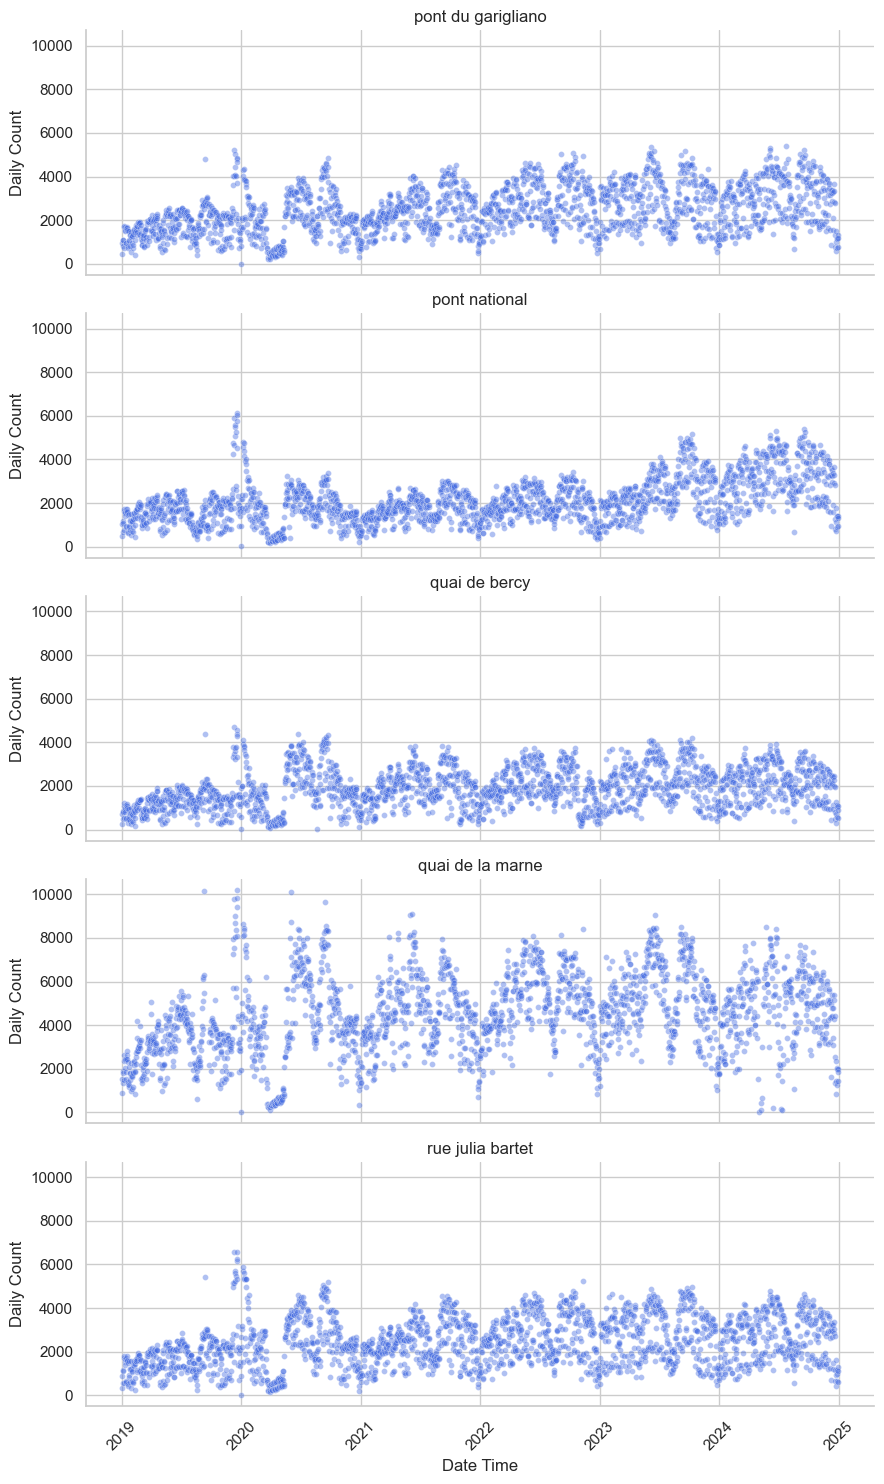

In [41]:
sns.set(style="whitegrid")  

g = sns.relplot(
    data=site_counts,
    x='date_time_dt',
    y='count',
    kind='scatter',
    col='site_name',
    col_wrap=1,
    s=18,       
    alpha=0.42,
    color='royalblue',
    height=3,
    aspect=3
)

g.set_axis_labels("Date Time", "Daily Count")
g.set_titles("{col_name}")
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

---

## Data Aggregation and Normalization Approach

The goal of the analysis is to model the relationship between hourly weather conditions and hourly cycling behavior, as estimated by bike traffic counts at five monitoring sites.

To focus on behavioral responses to weather rather than absolute traffic volumes, hourly counts were first aggregated across counters to obtain site-level estimates of cycling activity.

Site-level hourly counts were then normalized relative to site-specific 2019 baselines, computed separately for each hour of day. This normalization preserves the diurnal structure of cycling activity while enabling meaningful comparisons across sites with different baseline traffic levels.

In [57]:
# copy data
df3 = df2.copy() 

# extract time-of-day hour column
df3['hour'] = df3['date_time_dt'].dt.hour

# commute site-level counts
site_hourly = (
    df3
    .groupby(['site_id', 'site_name','date_time_dt', 'year', 'day','hour'], as_index=False)['count']
    .sum(min_count = 1)
)

dn = site_hourly[site_hourly['year'] == '2019']

# compute hourly medians for 2019
site_hourly_medians_2019 = (
    dn
    .groupby(['site_id','hour'], as_index=False)['count']
    .median()
    .rename(columns={'count': 'median_2019'})
)

# compute hourly irq for 2019
site_hourly_iqr_2019 = (
    dn
    .groupby(['site_id','hour'], as_index=False)['count']
    .agg(iqr)
    .rename(columns={'count': 'iqr_2019'})

)

# merge
site_hourly = site_hourly.merge(
    site_hourly_medians_2019, on=['site_id','hour'], how='left'
)
site_hourly = site_hourly.merge(
    site_hourly_iqr_2019, on=['site_id','hour'], how='left'
)

# normalized_count = (hourly_site_count − hourly_site_median_2019) / hourly_site_IQR_2019)
site_hourly['count_std'] = ((site_hourly['count'] - site_hourly['median_2019']) / site_hourly['iqr_2019'].replace(0, np.nan))

# drop temporary columns
site_hourly = site_hourly.drop(columns = ['median_2019','iqr_2019'])

# reorder columns
df4 = site_hourly[['site_id', 'site_name', 
                   'date_time_dt','year', 'day', 'hour',
                   'count', 'count_std'
                 ]]

display(df4)
display(df4['count_std'].isna().sum())

,site_id,site_name,date_time_dt,year,day,hour,count,count_std
0,100047535-100047551,pont du garigliano,2019-01-01 00:00:00+01:00,2019,2019-01-01,0,9,-0.5
1,100047535-100047551,pont du garigliano,2019-01-01 01:00:00+01:00,2019,2019-01-01,1,13,0.857143
2,100047535-100047551,pont du garigliano,2019-01-01 02:00:00+01:00,2019,2019-01-01,2,18,2.333333
3,100047535-100047551,pont du garigliano,2019-01-01 03:00:00+01:00,2019,2019-01-01,3,15,3.0
4,100047535-100047551,pont du garigliano,2019-01-01 04:00:00+01:00,2019,2019-01-01,4,5,0.666667
...,...,...,...,...,...,...,...,...
262661,100047547,rue julia bartet,2024-12-31 19:00:00+01:00,2024,2024-12-31,19,64,-0.712803
262662,100047547,rue julia bartet,2024-12-31 20:00:00+01:00,2024,2024-12-31,20,47,-0.596491
262663,100047547,rue julia bartet,2024-12-31 21:00:00+01:00,2024,2024-12-31,21,18,-0.860215
262664,100047547,rue julia bartet,2024-12-31 22:00:00+01:00,2024,2024-12-31,22,15,-0.630435


556

### Visualize Standardized Count Distributions

Across sites, the standardized hourly count distributions exhibit pronounced right-skewed tails, indicating occasional periods of substantially elevated cycling activity relative to baseline. These extreme values are rare and do not dominate the distributions. While their specific causes are not understood at this stage, subsequent sections examine contextual factors (e.g., calendar effects and weather) that may help explain such deviations.

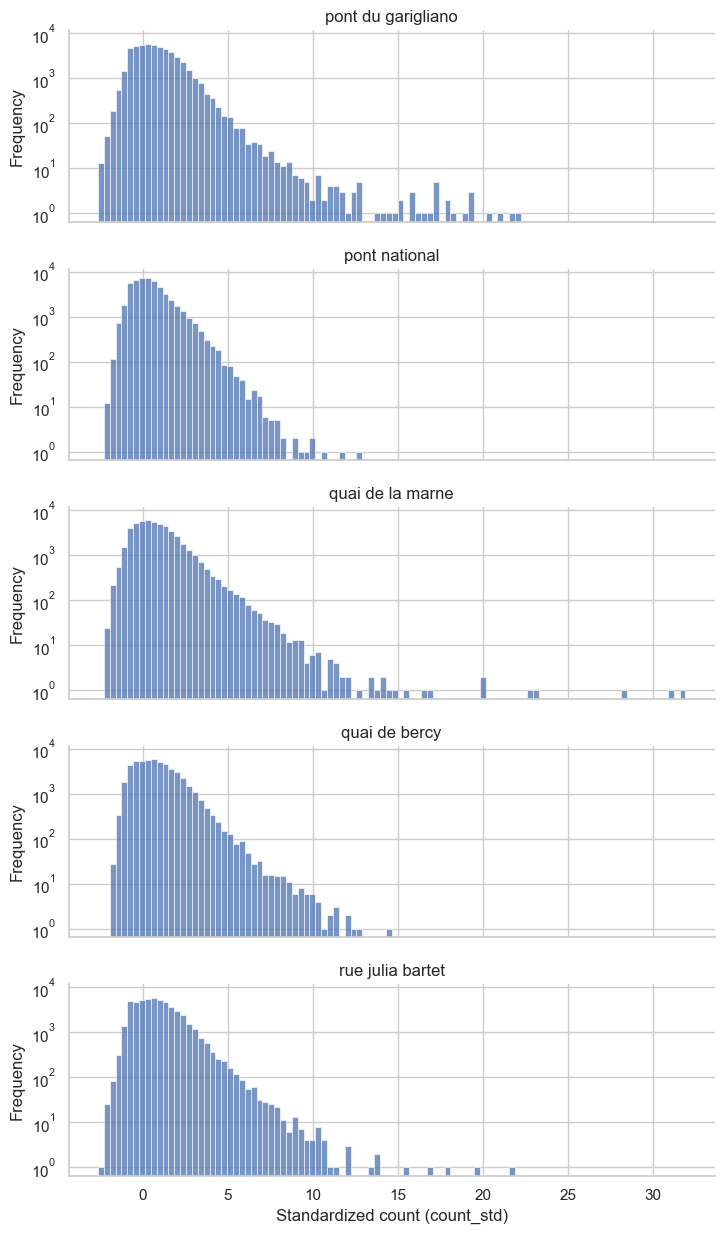

In [65]:
sns.set(style="whitegrid")  

sns.set(style="whitegrid", context="notebook")

g = sns.displot(
    data=df4,                
    x="count_std",
    col="site_name",
    col_wrap=1,
    bins=100,
    common_norm=False,            
    height=2.5,
    aspect=3
)

for ax in g.axes.flat:
    ax.set_yscale("log")

g.set_axis_labels("Standardized count (count_std)", "Frequency")
g.set_titles("{col_name}")

plt.show()

### Boxplot of count_std by Hour

Here count_std values are visualized by hour. The majority of the extreme count_std values occur in nighttime/early morning hours. 

<Axes: title={'center': 'count_std'}, xlabel='hour'>

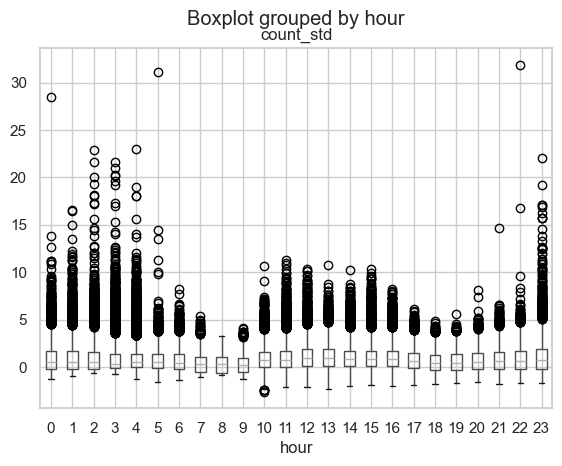

In [64]:
df4.boxplot(by = "hour", column = ['count_std'])

### Note on Missing Values

A total of 556 values (out of 262,666) are missing in count_std. These arise when the site–hour baseline interquartile range (IQR) is zero, making the standardization undefined. Such cases occur primarily during very low-activity hours where site-level counts show little or no variability.

---